In [1]:
from mel2wave_model_viaSpec import Mel2Wave
from mel2wave_data import ToData
import config
import torch
from torch.utils import data as DataUtil
import h5py
import pytorch_lightning as pl

In [2]:
uselen = 16
class OriginalData(DataUtil.Dataset):
    def __init__(self) -> None:
        super().__init__()

        with h5py.File(ToData.file_name,'r',swmr=True) as f:
            self.data = torch.from_numpy(f[ToData.data_key][:uselen])
            self.ans = torch.from_numpy(f[ToData.answer_key][:uselen])
        print(self.data.shape,self.ans.shape)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):
        return self.data[index],self.ans[index]

data_set = OriginalData()

torch.Size([20, 128, 64]) torch.Size([20, 1, 20800])


In [5]:
model = Mel2Wave()
batch_size = 16
EPOCHS = 1000
data_loader = DataUtil.DataLoader(data_set,batch_size,shuffle=True,num_workers=0,pin_memory=False)

In [6]:
trainer = pl.Trainer(gpus=1,num_nodes=1,precision=16,max_epochs=EPOCHS)
trainer.fit(model,data_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | MSELoss          | 0     
1 | mel2spec  | Mel2Spec         | 163 K 
2 | ch_conv   | ConvNorm1d       | 72    
3 | DDU0      | DilatedDepthUnit | 2.5 K 
4 | out_conv  | Conv1d           | 81    
-----------------------------------------------
166 K     Trainable params
0         Non-trainable params
166 K     Total params
0.664     Total estimated model params size (MB)


Epoch 475:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=0.00138, v_num=15]

C:\Users\22shi\anaconda3\envs\JARVIS\lib\site-packages\pytorch_lightning\trainer\trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


In [7]:
from datetime import datetime
now = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
name = f'params/Mel2Wave_viaSpec_{now}.params'
torch.save(model.state_dict(),name)
print('saved')

saved


In [8]:
viewlen = 10
with torch.no_grad():
    model.eval()
    model.cuda()
    model.half()
    data = data_set.data[:viewlen].cuda()
    ans = data_set.ans[:viewlen].numpy()
    out = model(data).cpu().detach().numpy()

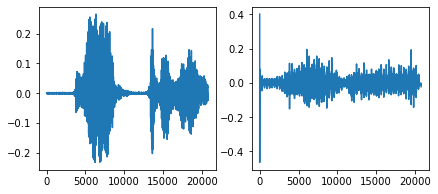

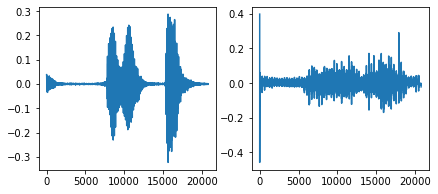

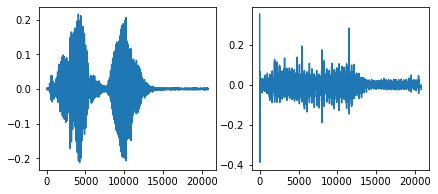

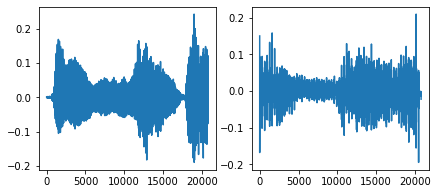

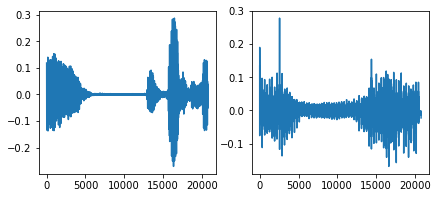

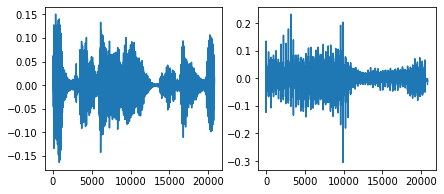

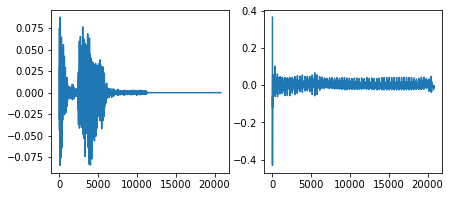

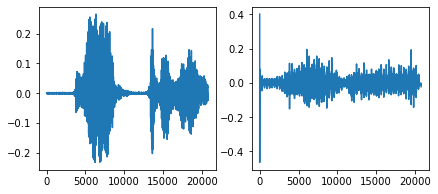

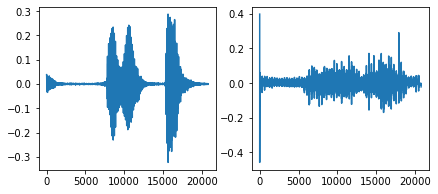

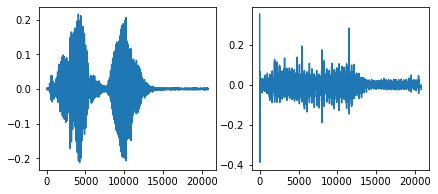

In [9]:
import matplotlib.pyplot as plt
for i in range(len(ans)):
    fig,ax = plt.subplots(1,2,figsize=(7,3))
    ax[0].plot(ans[i].reshape(-1))
    ax[1].plot(out[i].reshape(-1))
    plt.show()


In [ ]:
from IPython.display import Audio,display
print('answer')
for i in ans:
    display(Audio(i,rate=config.frame_rate))
print('output')
for i in out:
    display(Audio(i,rate=config.frame_rate))


In [4]:
#model.load_state_dict(torch.load('params/Mel2Wave_2021-07-11_15-52-10.params'))

<All keys matched successfully>